In [2]:
import numpy as np
import pandas as pd
import scipy.io as io 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 
import torch
import torch.nn as nn 
from envs import ShellEnv
from utils import make_env, criterion
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

sns.set_style('whitegrid')

In [11]:
data = []
indices = [] 

qr_pairs = [
    (1, 1)
]

times = 10

for i in range(times):
    # noise = np.random.normal(0, 0.1, (100, 3))
    # noise = io.loadmat('./mpcLog/dsim_'+str(i+1)+'.mat')['dsim'].reshape(-1, 3) * 2
    noise = None 
    for q, r in qr_pairs:
        zeta = r / q  
        env = make_env('test', q=q, r=r, goal=1)
        model = PPO.load('./1216/q_'+str(q)+'_r_'+str(r)+'/Evalpoint/best_model.zip', env=env)
        s = env.reset()
        step = 0 
        while True:
            step += 1 
            if noise is not None: 
                attacked_s = s.copy()
                attacked_s[3:6, -1] += noise[step-1, :]
                a, _ = model.predict(attacked_s, deterministic=True)
            else: 
                a, _ = model.predict(s, deterministic=True)
            s_, r, d, _ = env.step(a)

            '''
            ['type', 'value', 'num_test', 'index', 'step', '$\zeta$']
            '''
            y = s[:3, -1] - s[3:6, -1]
            du = a * 0.05
            data.append(['y', y[0], i+1, 1, step, zeta])
            data.append(['y', y[1], i+1, 2, step, zeta])
            data.append(['y', y[2], i+1, 3, step, zeta])
            data.append(['du', du[0], i+1, 1, step, zeta])
            data.append(['du', du[1], i+1, 2, step, zeta])
            data.append(['du', du[2], i+1, 3, step, zeta])
            
            if d:
                break
            s = s_ 

df = pd.DataFrame(
    data = data,
    columns=['type', 'value', 'num_test', 'index', 'step', '$\zeta$']
) 

df.sort_values(
    by=['num_test', '$\zeta$', 'type', 'step']
)

for i in range(times):
    tmp_y = np.concatenate(
        (
            np.array(df[(df['num_test'] == i+1) & (df['type'] == 'y') & (df['index'] == 1)]['value']).reshape(-1, 1),
            np.array(df[(df['num_test'] == i+1) & (df['type'] == 'y') & (df['index'] == 2)]['value']).reshape(-1, 1),
            np.array(df[(df['num_test'] == i+1) & (df['type'] == 'y') & (df['index'] == 3)]['value']).reshape(-1, 1),
        ), axis=1,
    )
    iae, ise, itae, itse = criterion(tmp_y, 1)
    indices.append([iae, ise, itae, itse, i+1])

indices_df = pd.DataFrame(
    data = indices,
    columns=['IAE', 'ISE', 'ITAE', 'ITSE', 'num_test']
)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [12]:
print(indices_df['IAE'].mean())
print(indices_df['ISE'].mean())
print(indices_df['ITAE'].mean())
print(indices_df['ITSE'].mean())

25.32221444679167
20.92747963448836
168.48590081432465
102.1234993718685


In [12]:
path = './mpcLog/'
mpc_data = [] 
mpc_indices = [] 

for i in range(times): 
    mpc_y = io.loadmat(path+'ysim_'+str(i+1)+'.mat')['ysim'] 
    mpc_du = io.loadmat(path+'dusim_'+str(i+1)+'.mat')['dusim'] 
    mpc_u = io.loadmat(path+'usim_'+str(i+1)+'.mat')['usim'] 
    step = 0 
    for t in range(mpc_y.shape[0]):
        step += 1 
        mpc_data.append(['y', mpc_y[t, 0], i+1, 1, step, 'MPC'])
        mpc_data.append(['y', mpc_y[t, 1], i+1, 2, step, 'MPC'])
        mpc_data.append(['y', mpc_y[t, 2], i+1, 3, step, 'MPC'])
        mpc_data.append(['du', mpc_du[t, 0], i+1, 1, step, 'MPC'])
        mpc_data.append(['du', mpc_du[t, 1], i+1, 2, step, 'MPC'])
        mpc_data.append(['du', mpc_du[t, 2], i+1, 3, step, 'MPC'])

mpc_df = pd.DataFrame(
    data = mpc_data,
    columns=['type', 'value', 'num_test', 'index', 'step', '$\zeta$'],
)

mpc_df.sort_values(
    by=['num_test', 'type', 'step']
)

for i in range(times):
    tmp_y = np.concatenate(
        (
            np.array(mpc_df[(mpc_df['num_test'] == i+1) & (mpc_df['type'] == 'y') & (mpc_df['index'] == 1)]['value']).reshape(-1, 1),
            np.array(mpc_df[(mpc_df['num_test'] == i+1) & (mpc_df['type'] == 'y') & (mpc_df['index'] == 2)]['value']).reshape(-1, 1),
            np.array(mpc_df[(mpc_df['num_test'] == i+1) & (mpc_df['type'] == 'y') & (mpc_df['index'] == 3)]['value']).reshape(-1, 1),
        ), axis=1,
    )
    iae, ise, itae, itse = criterion(tmp_y, 1)
    mpc_indices.append([iae, ise, itae, itse, i+1])

mpc_indices_df = pd.DataFrame(
    data = mpc_indices,
    columns=['IAE', 'ISE', 'ITAE', 'ITSE', 'num_test']
)

In [13]:
print(mpc_indices_df['IAE'].mean())
print(mpc_indices_df['ISE'].mean())
print(mpc_indices_df['ITAE'].mean())
print(mpc_indices_df['ITSE'].mean())

41.47406003919531
23.19311936118337
1037.3098384384714
209.12619798480387


### $y$ plot 

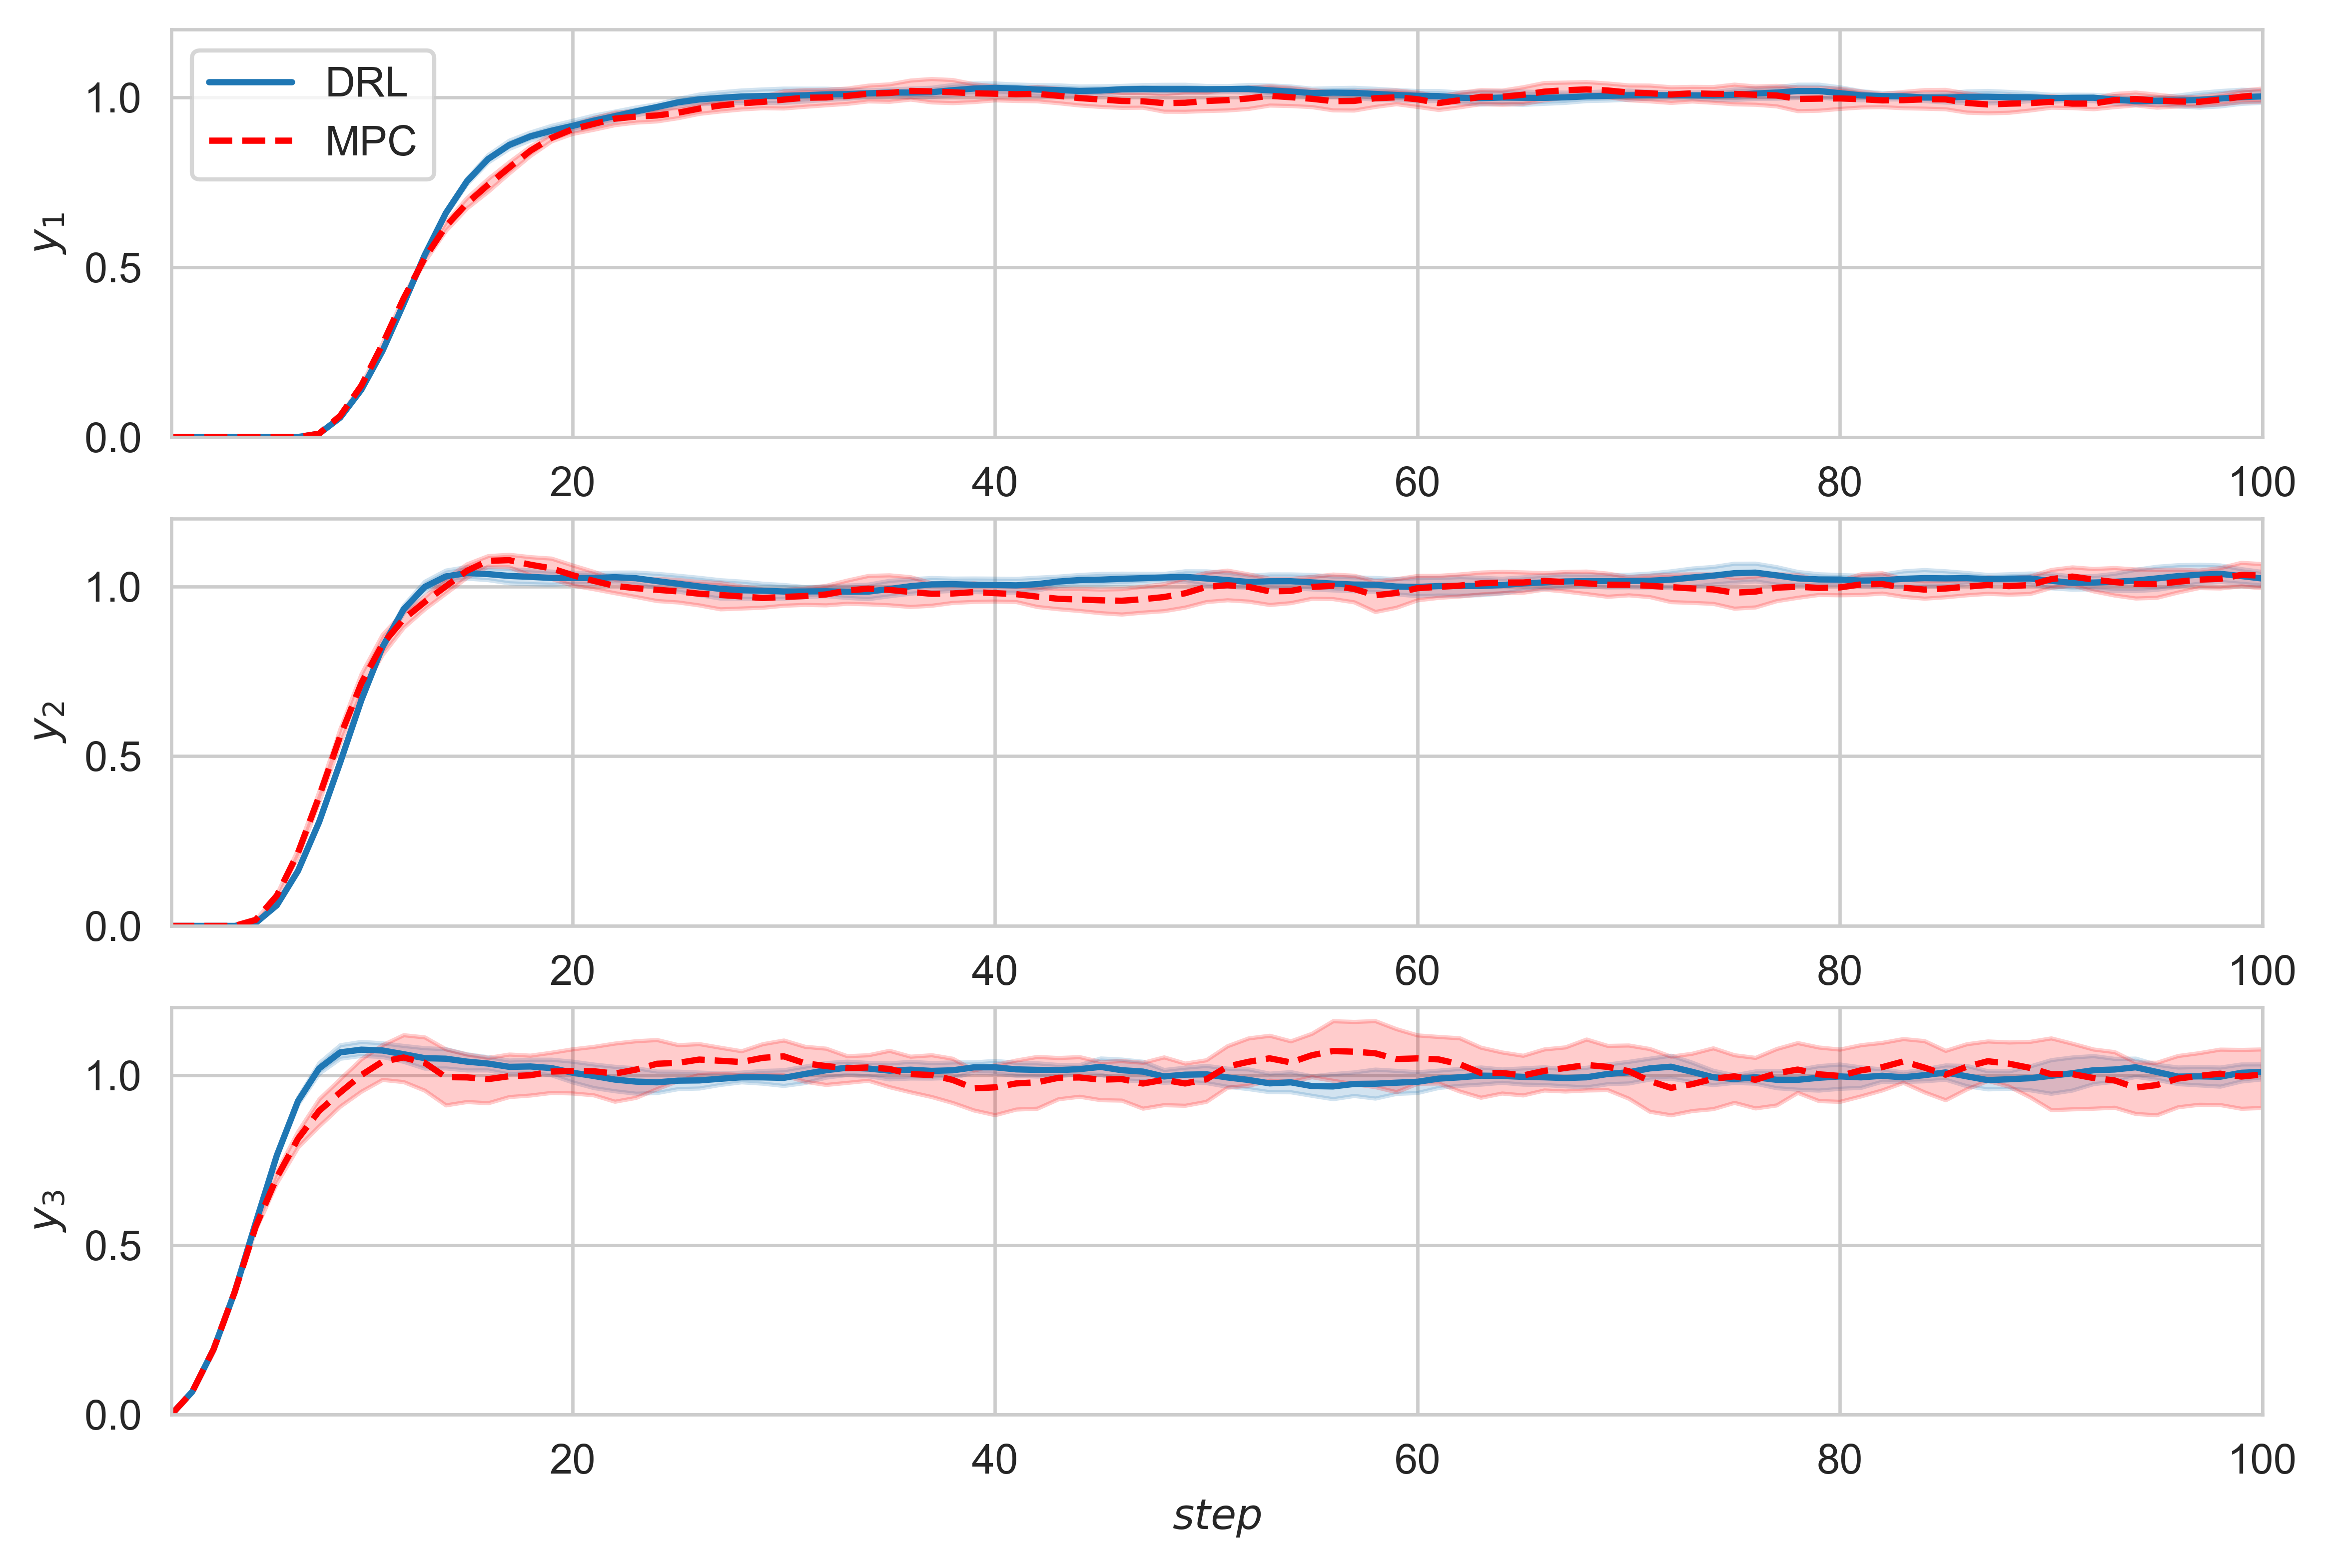

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(9, 6), dpi=600)
sns.lineplot(data=df[(df['type']=='y') & (df['index'] == 1)], x='step', y='value', hue='$\zeta$', palette='tab10', ax=axs[0], label='DRL', legend=None)
sns.lineplot(data=df[(df['type']=='y') & (df['index'] == 2)], x='step', y='value', hue='$\zeta$', palette='tab10', ax=axs[1], legend=None)
sns.lineplot(data=df[(df['type']=='y') & (df['index'] == 3)], x='step', y='value', hue='$\zeta$', palette='tab10', ax=axs[2], legend=None)

sns.lineplot(data=mpc_df[(mpc_df['type']=='y') & (mpc_df['index'] == 1)], x='step', y='value', hue='$\zeta$', palette=['r'], ax=axs[0], label='MPC', legend=None)
sns.lineplot(data=mpc_df[(mpc_df['type']=='y') & (mpc_df['index'] == 2)], x='step', y='value', hue='$\zeta$', palette=['r'], ax=axs[1], legend=None)
sns.lineplot(data=mpc_df[(mpc_df['type']=='y') & (mpc_df['index'] == 3)], x='step', y='value', hue='$\zeta$', palette=['r'], ax=axs[2], legend=None)
# axs[0].plot(np.array(range(100))+1 ,mpc_y[:, 0], 'r--', label='MPC')
# axs[1].plot(np.array(range(100))+1 ,mpc_y[:, 1], 'r--')
# axs[2].plot(np.array(range(100))+1 ,mpc_y[:, 2], 'r--')

for ax in axs:
    # ax.lines[0].set_color('b')
    ax.lines[1].set_linestyle('--')
    ax.set_xlim([1, 100])
    ax.set_ylim([0, 1.2])
axs[0].set_ylabel('$y_1$')
axs[1].set_ylabel('$y_2$')
axs[2].set_ylabel('$y_3$')
axs[2].set_xlabel('$step$')

axs[0].legend()

### $\Delta u$ / $u$ plot 

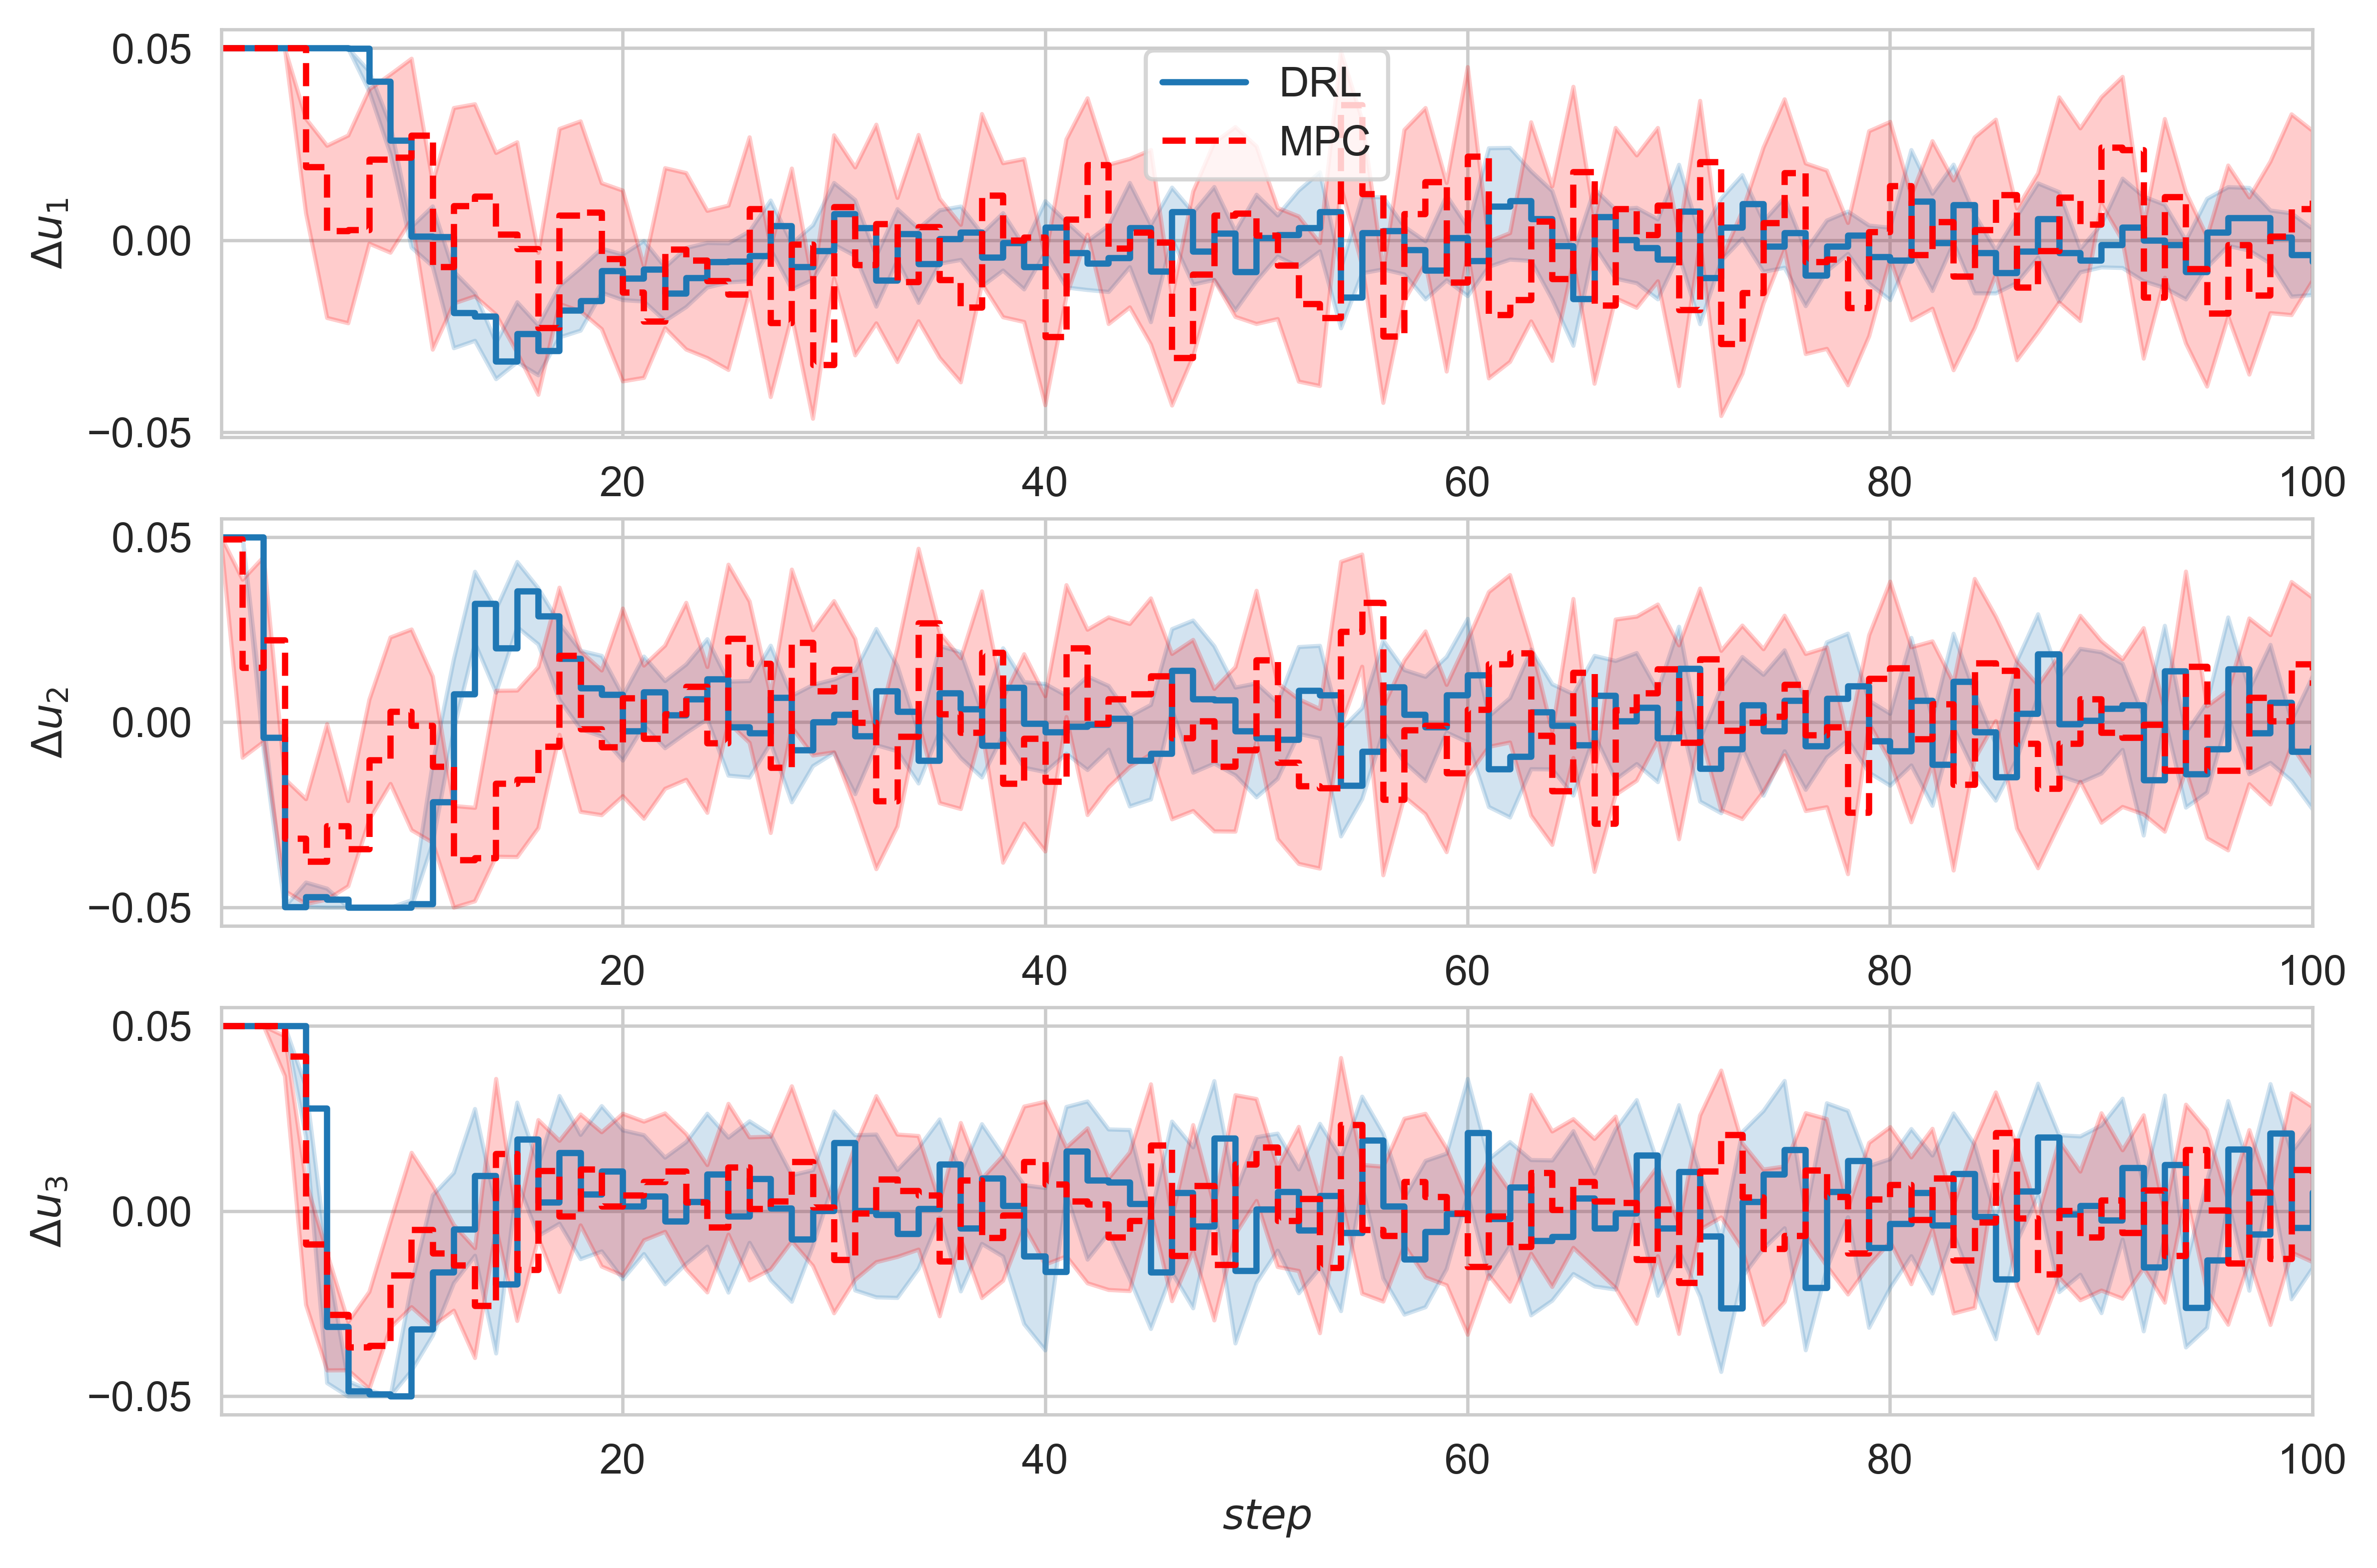

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(9, 6), dpi=600)
sns.lineplot(data=df[(df['type']=='du') & (df['index'] == 1)], x='step', y='value', hue='$\zeta$' , drawstyle='steps-post', palette='tab10', ax=axs[0], label='DRL', legend=None)
sns.lineplot(data=df[(df['type']=='du') & (df['index'] == 2)], x='step', y='value', hue='$\zeta$' , drawstyle='steps-post', palette='tab10', ax=axs[1], legend=None)
sns.lineplot(data=df[(df['type']=='du') & (df['index'] == 3)], x='step', y='value', hue='$\zeta$' , drawstyle='steps-post', palette='tab10', ax=axs[2], legend=None)

sns.lineplot(data=mpc_df[(mpc_df['type']=='du') & (mpc_df['index'] == 1)], x='step', y='value', hue='$\zeta$', palette=['r'], drawstyle='steps-post', ax=axs[0], label='MPC', legend=None)
sns.lineplot(data=mpc_df[(mpc_df['type']=='du') & (mpc_df['index'] == 2)], x='step', y='value', hue='$\zeta$', palette=['r'], ax=axs[1], drawstyle='steps-post', legend=None)
sns.lineplot(data=mpc_df[(mpc_df['type']=='du') & (mpc_df['index'] == 3)], x='step', y='value', hue='$\zeta$', palette=['r'], ax=axs[2], drawstyle='steps-post', legend=None)

for ax in axs:
    ax.set_xlim([1, 100])
    # ax.set_ylim([0, 1.2])
    ax.lines[-1].set_linestyle('--')
axs[0].set_ylabel('$\Delta u_1$')
axs[1].set_ylabel('$\Delta u_2$')
axs[2].set_ylabel('$\Delta u_3$')
axs[2].set_xlabel('$step$')

axs[0].legend()

In [48]:
path = './mpcLog/'
mpc_y = io.loadmat(path+'ysim.mat')['ysim'] 
mpc_du = io.loadmat(path+'dusim.mat')['dusim'] 
mpc_u = io.loadmat(path+'usim.mat')['usim'] 